In [2]:
# Import libraries
import pandas as pd
import numpy as np
from numpy import *

# Plotting library
import matplotlib
import matplotlib.pyplot as plt

# Plot settings
matplotlib.rcParams['figure.figsize'] = [14.0, 8.0]
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['lines.linewidth'] = 2.0

# Interactive plotting
import cufflinks as cf
cf.set_config_file(offline=True)

In [3]:
# subsume list of inputs into a dataframe
cds = pd.DataFrame({'Maturity': [1, 2, 3, 5, 7], 
                   'WFC': [50, 77, 94, 125, 133],
                   'CCMO': [751, 1164, 1874, 4156, 6083],
                   'Df': [0.97, 0.94, 0.92, 0.86, 0.81]})
# output
cds

,Maturity,WFC,CCMO,Df
0,1,50,751,0.97
1,2,77,1164,0.94
2,3,94,1874,0.92
3,5,125,4156,0.86
4,7,133,6083,0.81


In [4]:
def get_discount_factor(maturity, discountfactor, tenor):
    
    max_time_index = len(maturity) - 1
    
    if tenor == 0: Df = 1.
    if tenor > 0 and tenor < maturity[0]: Df = discountfactor[0]
    if tenor >= maturity[max_time_index]: Df = discountfactor[max_time_index]
        
    for i in range(0, max_time_index):
         if tenor >= maturity[i] and tenor < maturity[i+1]:
            term1 = ((tenor-maturity[i])/(maturity[i+1] - maturity[i]))*log(discountfactor[i+1])
            term2 = ((maturity[i+1]-tenor)/(maturity[i+1] - maturity[i]))*log(discountfactor[i])
            lnDf = term1 + term2
            Df = exp(lnDf)
            
    return Df

In [5]:
t = np.arange(8)
Df = np.zeros(len(t))
for i in range(0, len(t)):
    Df[i] = get_discount_factor(cds.Maturity,cds.Df,t[i])

print(f'Discount Factors: {Df}')

Discount Factors: [1.         0.97       0.94       0.92       0.88949424 0.86
 0.83462566 0.81      ]


In [6]:
# interpolation WFC spreads
wfc = np.interp(t,cds.Maturity,cds.WFC)

# set spreads to zero at t=0
wfc[0] = 0

# interpolation CCMO spreads
ccmo = np.interp(t,cds.Maturity,cds.CCMO)

# set spreads to zero at t=0
ccmo[0] = 0

In [7]:
# output the results
print(f'WFC Spreads: \t {wfc}')
print(f'CCMO Spreads: \t {ccmo}')

WFC Spreads: 	 [  0.   50.   77.   94.  109.5 125.  129.  133. ]
CCMO Spreads: 	 [   0.   751.  1164.  1874.  3015.  4156.  5119.5 6083. ]


In [8]:
# subsume list of inputs into a dataframe
df = pd.DataFrame({'Maturity': t, 
                   'WFC': wfc,
                   'CCMO': ccmo,
                   'Df': Df})
# output
df

,Maturity,WFC,CCMO,Df
0,0,0.0,0.0,1.000000
1,1,50.0,751.0,0.970000
2,2,77.0,1164.0,0.940000
3,3,94.0,1874.0,0.920000
4,4,109.5,3015.0,0.889494
5,5,125.0,4156.0,0.860000
6,6,129.0,5119.5,0.834626
7,7,133.0,6083.0,0.810000


In [9]:
def get_survival_probability(maturity, discountfactor, spread, recovery, plot_prob=False, plot_hazard=False):
    
    # subsume list of inputs into a dataframe
    df = pd.DataFrame({'Maturity': maturity, 'Df': discountfactor, 'Spread': spread})
    
    # convert bps to decimal
    df['Spread'] = df['Spread']/10000

    # specify delta_t
    df['Dt'] = df['Maturity'].diff().fillna(0)

    # loss rate
    L = 1.0 - recovery
    
    # initialize the variables
    term = term1 = term2 = divider = 0
    
    for i in range(0, len(df.index)):
        if i == 0: df.loc[i,'Survival'] = 1; df.loc[i, 'Hazard'] = 0
        if i == 1: df.loc[i,'Survival'] = L / (L+df.loc[i,'Dt']*df.loc[i,'Spread']); \
            df.loc[i, 'Hazard'] = -log(df.loc[i,'Survival']/df.loc[i-1,'Survival'])/df.loc[i,'Dt']
        if i > 1:
            terms = 0
            for j in range(1, i):
                term = df.loc[j,'Df']*(L*df.loc[j-1,'Survival'] - \
                                              (L + df.loc[j,'Dt']*df.loc[i,'Spread'])* \
                                              df.loc[j,'Survival'])
                terms = terms + term  
           
            divider = df.loc[i,'Df']*(L+df.loc[i,'Dt']*df.loc[i,'Spread'])
            term1 = terms/divider

            term2 = (L*df.loc[i-1,'Survival']) / (L + (df.loc[i,'Dt'] * df.loc[i,'Spread']))

            df.loc[i,'Survival'] = term1 + term2
            
            if (df.loc[i,'Survival'] >= 0 and df.loc[i-1,'Survival'] >= 0):
                df.loc[i, 'Hazard'] = -log(df.loc[i,'Survival']/df.loc[i-1,'Survival'])/df.loc[i,'Dt']
    
    # derive probability of default
    df['Default'] = 1. - df['Survival']
    
    # derive marginal probability of default
    df['Marginal'] = df['Survival'].diff().fillna(0)
    
    if plot_prob:
        # plot survival probability
        df[['Survival', 'Default']].iplot(title='Survival vs Default Probability', 
                                          xTitle='CDS Maturity', 
                                          yTitle='Survival Probability', 
                                          secondary_y = 'Default', 
                                          secondary_y_title='Default Probability')
        
    if plot_hazard:
        # plot survival probability
        df['Hazard'].iplot(kind='bar', title='Term Structure of Hazard Rates', 
                                          xTitle='CDS Maturity', 
                                          yTitle='Hazard Rates')

    return df

In [10]:
WFC = get_survival_probability(df.Maturity,df.Df,df.WFC,0.50,plot_prob=True,plot_hazard=True)
WFC

,Maturity,Df,Spread,Dt,Survival,Hazard,Default,Marginal
0,0,1.000000,0.00000,0.0,1.000000,0.000000,0.000000,0.000000
1,1,0.970000,0.00500,1.0,0.990099,0.009950,0.009901,-0.009901
2,2,0.940000,0.00770,1.0,0.969649,0.020871,0.030351,-0.020450
3,3,0.920000,0.00940,1.0,0.944966,0.025785,0.055034,-0.024683
4,4,0.889494,0.01095,1.0,0.915366,0.031825,0.084634,-0.029600
5,5,0.860000,0.01250,1.0,0.880536,0.038793,0.119464,-0.034830
6,6,0.834626,0.01290,1.0,0.854360,0.030178,0.145640,-0.026176
7,7,0.810000,0.01330,1.0,0.827388,0.032079,0.172612,-0.026972


In [11]:
# plot probabilities for various recovery rate
sp = pd.DataFrame()

for i in arange(0.1, 1, 0.1):
    sp[i] = get_survival_probability(df.Maturity,df.Df,df.WFC,i)['Survival']

sp.columns = around(sp.columns*100)
sp.iplot(title='Survival Probability for various Recovery Rate',
         xTitle='CDS Maturity', 
         yTitle='Survival Probability',
         labels = sp.columns)

In [12]:
# surface plot 
sp.iplot(kind='surface', title='Relationship of Survival Probability, Maturity & Recovery Rate')

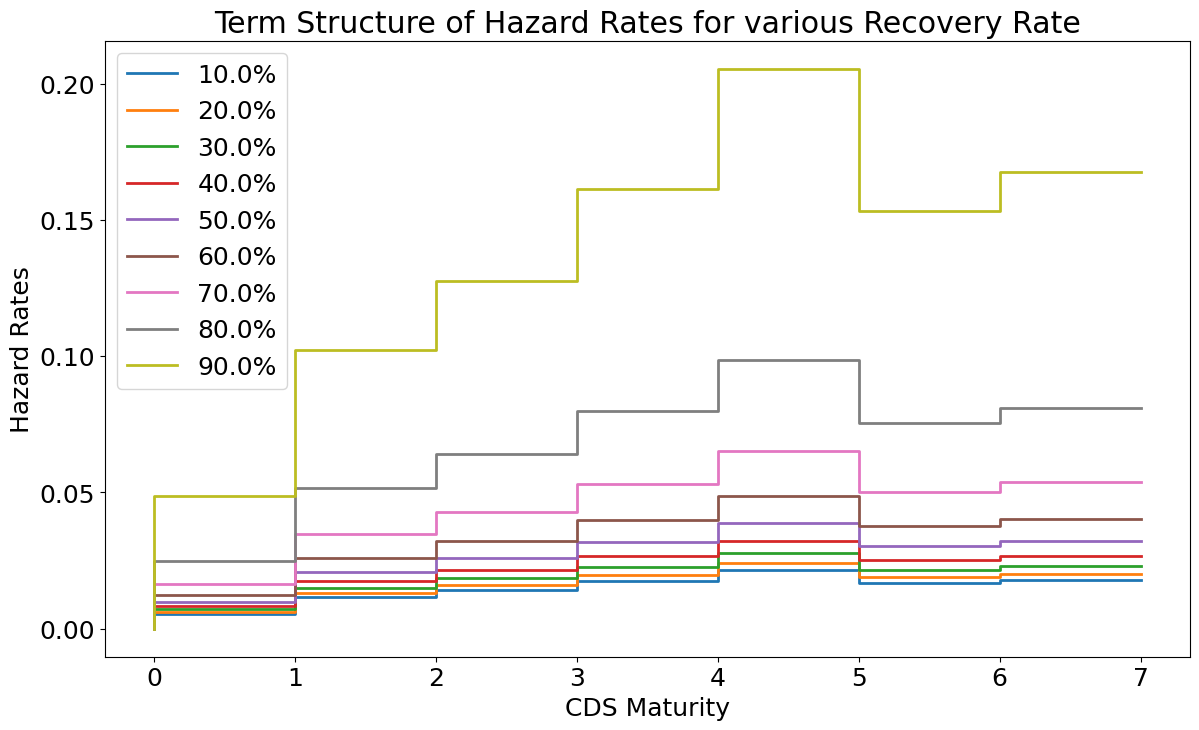

In [13]:
hz = pd.DataFrame()

for i in arange(0.1, 1, 0.1):
    hz[i] = get_survival_probability(df.Maturity,df.Df,df.WFC,i)['Hazard']
    plt.step(hz.index, hz[i], label =f'{i*100:0.4}%')

plt.title('Term Structure of Hazard Rates for various Recovery Rate')
plt.xlabel('CDS Maturity')
plt.ylabel('Hazard Rates')
plt.legend();

In [14]:
CCMO = get_survival_probability(df.Maturity,df.Df,df.CCMO,0.10,plot_prob=True)

In [19]:
from QuantLib import *

In [16]:
# inputs
maturity = np.arange(6)
discountfactor = [0, 0.97, 0.94, 0.92, 0.89, 0.86]
cds_spread = [0, 50, 77, 94, 109.5, 125]
recovery = 0.40

sp = get_survival_probability(maturity,discountfactor,cds_spread,recovery)
sp

,Maturity,Df,Spread,Dt,Survival,Hazard,Default,Marginal
0,0,0.00,0.00000,0.0,1.000000,0.000000,0.000000,0.000000
1,1,0.97,0.00500,1.0,0.991736,0.008299,0.008264,-0.008264
2,2,0.94,0.00770,1.0,0.974623,0.017406,0.025377,-0.017113
3,3,0.92,0.00940,1.0,0.953894,0.021498,0.046106,-0.020728
4,4,0.89,0.01095,1.0,0.928942,0.026506,0.071058,-0.024952
5,5,0.86,0.01250,1.0,0.899443,0.032271,0.100557,-0.029500


In [20]:
# set up
calendar = TARGET()

todaysDate = Date(14, December, 2020)
Settings.instance().evaluationDate = todaysDate

risk_free_rate = YieldTermStructureHandle(FlatForward(todaysDate, 0.0, Actual365Fixed()))

In [21]:
# CDS parameters
recovery_rate = 0.4
quoted_spreads = [0.005, 0.0077, 0.0094, 0.01095, 0.0125]
tenors = [Period(1, Years), 
          Period(2, Years), 
          Period(3, Years), 
          Period(4, Years),
          Period(5, Years)]
maturities = [calendar.adjust(todaysDate + x, Following) for x in tenors]

instruments = [
    SpreadCdsHelper(
        QuoteHandle(SimpleQuote(s)),
        tenor,
        0,
        calendar,
        Annual,
        Following,
        DateGeneration.TwentiethIMM,
        Actual365Fixed(),
        recovery_rate,
        risk_free_rate,
    )
    for s, tenor in zip(quoted_spreads, tenors)
]

# calculate hazard rate
hazard_curve = PiecewiseFlatHazardRate(todaysDate, instruments, Actual365Fixed())
print("---"*10)
print("Calibrated hazard rate values: ")
print("---"*10)
for x in hazard_curve.nodes():
    print("hazard rate on %s is %.7f" % x)

survival_probability = list(sp['Survival'])[1:]
temp = list(zip(maturities, survival_probability))

# calculate survival probability 
print("---"*10)
print("Survival probability values: ")
print("---"*10)
counter = 1
for each in temp:
    print(f"{counter}Y survival probability:{hazard_curve.survivalProbability(each[0]):.6}, \n\t\texpected {each[1]:.6}")
    counter = counter + 1

------------------------------
Calibrated hazard rate values: 
------------------------------
hazard rate on December 14th, 2020 is 0.0083108
hazard rate on December 20th, 2021 is 0.0083108
hazard rate on December 20th, 2022 is 0.0174544
hazard rate on December 20th, 2023 is 0.0215227
hazard rate on December 20th, 2024 is 0.0263435
hazard rate on December 22nd, 2025 is 0.0318521
------------------------------
Survival probability values: 
------------------------------
1Y survival probability:0.991724, 
		expected 0.991736
2Y survival probability:0.97471, 
		expected 0.974623
3Y survival probability:0.95402, 
		expected 0.953894
4Y survival probability:0.929088, 
		expected 0.928942
5Y survival probability:0.900094, 
		expected 0.899443


In [22]:
# reprice instruments
nominal = 1000000.0
probability = DefaultProbabilityTermStructureHandle(hazard_curve)

# create a cds for every maturity:
all_cds = []
for maturity, s in zip(maturities, quoted_spreads):
    schedule = Schedule(
        todaysDate,
        maturity,
        Period(Annual),
        calendar,
        Following,
        Unadjusted,
        DateGeneration.TwentiethIMM,
        False,
    )
    cds = CreditDefaultSwap(Protection.Seller, nominal, s, schedule, Following, Actual365Fixed())
    engine = MidPointCdsEngine(probability, recovery_rate, risk_free_rate)
    cds.setPricingEngine(engine)
    all_cds.append(cds)

print("---"*20)
print("Repricing of quoted CDS spreads employed for calibration: ")
print("---"*20)
for cds, tenor in zip(all_cds, tenors):
    print(f"{tenor} Fair spread : {cds.fairSpread():.6}")
    print(f"   NPV         : {cds.NPV():.6}")
    print(f"   default leg : {cds.defaultLegNPV():.6}")
    print(f"   coupon leg  : {cds.couponLegNPV():.6}")
    print("")

------------------------------------------------------------
Repricing of quoted CDS spreads employed for calibration: 
------------------------------------------------------------
1Y Fair spread : 0.00498647
   NPV         : 13.6986
   default leg : -5047.12
   coupon leg  : 5060.81

2Y Fair spread : 0.00768943
   NPV         : 21.0959
   default leg : -15341.5
   coupon leg  : 15362.6

3Y Fair spread : 0.0093913
   NPV         : 25.7534
   default leg : -27790.5
   coupon leg  : 27816.3

4Y Fair spread : 0.0109423
   NPV         : 30.0
   default leg : -42707.9
   coupon leg  : 42737.9

5Y Fair spread : 0.0124929
   NPV         : 34.2466
   default leg : -60179.1
   coupon leg  : 60213.4

